In [14]:
import lightgbm as lgb
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("HYBRID STACKING IMPLEMENTATION")
print("="*80)

HYBRID STACKING IMPLEMENTATION


In [15]:
np.random.seed(88)

In [16]:
# -----------------------------------------------------------------------------
# STEP 1: Define column names for the dataset
# -----------------------------------------------------------------------------

# These are the 14 attributes in the heart disease dataset
columns = [
    "age",       # Age in years
    "sex",       # Sex (1 = male; 0 = female)
    "cp",        # Chest pain type (1-4)
    "trestbps",  # Resting blood pressure (mm Hg)
    "chol",      # Serum cholesterol (mg/dl)
    "fbs",       # Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
    "restecg",   # Resting ECG results (0-2)
    "thalach",   # Maximum heart rate achieved
    "exang",     # Exercise induced angina (1 = yes; 0 = no)
    "oldpeak",   # ST depression induced by exercise
    "slope",     # Slope of peak exercise ST segment (1-3)
    "ca",        # Number of major vessels colored by fluoroscopy (0-3)
    "thal",      # Thalassemia (3 = normal; 6 = fixed defect; 7 = reversible)
    "target"     # Diagnosis (0 = no disease, 1-4 = disease severity)
]

In [17]:
# -----------------------------------------------------------------------------
# STEP 2: Load and combine datasets from multiple locations
# -----------------------------------------------------------------------------
# The UCI heart disease database contains data from 4 locations
datasets = [
    "processed.cleveland.data",
    "processed.hungarian.data",
    "processed.switzerland.data",
    "processed.va.data"
]

df_list = []
for data_path in datasets:
    try:
        df = pd.read_csv(data_path, names=columns)
        # Replace '?' (missing value marker) with NaN
        df.replace('?', pd.NA, inplace=True)
        df_list.append(df)
        print(f"✓ Loaded {data_path}: {len(df)} rows")
    except FileNotFoundError:
        print(f"✗ Warning: {data_path} not found, skipping...")

# Combine all datasets vertically
combined = pd.concat(df_list, ignore_index=True)
print(f"\n Total combined rows: {len(combined)}")

✓ Loaded processed.cleveland.data: 303 rows
✓ Loaded processed.hungarian.data: 294 rows
✓ Loaded processed.switzerland.data: 123 rows
✓ Loaded processed.va.data: 200 rows

 Total combined rows: 920


In [18]:
# -----------------------------------------------------------------------------
# STEP 3: Handle missing values
# -----------------------------------------------------------------------------
print("\n Missing values before cleaning:")
print(combined.isnull().sum())

# Convert all columns to numeric (some may be strings due to '?')
for col in combined.columns:
    combined[col] = pd.to_numeric(combined[col], errors='coerce')

# Fill missing values with median (robust to outliers)
combined.fillna(combined.median(), inplace=True)

print("\n✓ Missing values after cleaning:")
print(combined.isnull().sum())

# Save the cleaned combined dataset
combined.to_csv("heart_disease_combined.csv", index=False)
print("\n Saved: heart_disease_combined.csv")


 Missing values before cleaning:
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

✓ Missing values after cleaning:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

 Saved: heart_disease_combined.csv


In [19]:
df_fe = combined.copy()

In [20]:
## --- A. Blood Pressure Features ---

# 1. Pulse Pressure (PP): Indicator of arterial stiffness. Higher is worse.
# Assuming 'trestbps' is Resting Blood Pressure
df_fe['pulse_pressure'] = df_fe['trestbps'] - df_fe['trestbps'].rolling(window=5).mean()
# A simpler version is just: df_fe['pulse_pressure'] = df_fe['trestbps'].diff()

# 2. Mean Arterial Pressure (MAP): More representative of perfusion pressure.
# Using a common approximation formula: MAP ≈ Diastolic + 1/3 * Pulse Pressure
# Since most datasets only have SBP ('trestbps'), we'll skip the accurate MAP calculation but note its importance.


## --- B. Cholesterol and Heart Rate Ratios ---

# 3. Cholesterol/Thalach Ratio: Contextualizes cholesterol against cardiovascular fitness.
# Lower 'thalach' (max heart rate) suggests lower fitness/cardiac reserve.
# Higher ratio indicates high cholesterol relative to heart performance.
df_fe['chol_thalach_ratio'] = df_fe['chol'] / df_fe['thalach']

# 4. Age and Cholesterol Interaction:
df_fe['age_chol_interaction'] = df_fe['age'] * df_fe['chol']


## --- C. Ischemic and Angina Interactions ---

# 5. Oldpeak/Thalach Ratio: Stress-induced ST depression relative to maximum achieved heart rate.
# High ST depression at low heart rate is a strong negative indicator.
df_fe['oldpeak_thalach_ratio'] = df_fe['oldpeak'] / df_fe['thalach']

# 6. Chest Pain Severity Score: Combine 'cp' and 'exang' (Exercise Induced Angina).
# Assuming 'cp' is categorical (1-4) and 'exang' is binary (0/1).
# We can create a weighted score where Angina (cp=4, or exang=1) contributes heavily.
# This assumes 'cp' is encoded such that higher values mean worse angina.
df_fe['angina_severity_score'] = df_fe['cp'] + (df_fe['exang'] * 2) # Multiply exang by 2 to give it extra weight

# 7. Zero-Inflated Features (Presence Flags):
# Create a binary feature for important zero-valued variables.
# Example: Create a flag for 'oldpeak' (ST depression) if it is zero.
df_fe['has_zero_oldpeak'] = (df_fe['oldpeak'] == 0).astype(int)

In [21]:
# --- A. One-Hot Encoding for Nominal Categorical Features ---
# Assume 'cp', 'restecg', 'slope', 'thal' are nominal/ordinal and need dummies.
# NOTE: Use 'drop_first=True' to avoid multicollinearity.
categorical_cols = ['cp', 'restecg', 'slope', 'thal']
df_fe = pd.get_dummies(df_fe, columns=categorical_cols, drop_first=True)


# --- B. Outlier Treatment and Scaling for Numerical Features ---
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak',
                  'pulse_pressure', 'chol_thalach_ratio', 'oldpeak_thalach_ratio', 'angina_severity_score']

# 1. Scaling: Standard Scaling is generally good for tree-based models (XGBoost/LGBM) and critical for linear/DL models (SVM/ANN).
# Using robust scaling or QuantileTransformer (non-linear transformation) can be an alternative SOTA approach.
scaler = StandardScaler()
df_fe[numerical_cols] = scaler.fit_transform(df_fe[numerical_cols])

# 2. Outlier/Skewness Treatment (Optional but Advanced):
quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=100)
df_fe[['chol', 'oldpeak']] = quantile_transformer.fit_transform(df_fe[['chol', 'oldpeak']])

print("\nFeature Engineering Complete. New DataFrame Shape:", df_fe.shape)
print("New Features Created:")
print(df_fe.columns[-10:])


Feature Engineering Complete. New DataFrame Shape: (920, 25)
New Features Created:
Index(['has_zero_oldpeak', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'restecg_1.0',
       'restecg_2.0', 'slope_2.0', 'slope_3.0', 'thal_6.0', 'thal_7.0'],
      dtype='object')


In [22]:
# Before proceeding to the next model, run this on your engineered DataFrame:
nan_counts = df_fe.isnull().sum()
if nan_counts.any():
    print("WARNING: NaN values found in the following columns:")
    print(nan_counts[nan_counts > 0])

    # Simple fix: Impute the NaNs (e.g., with the mean of the column)
    # The NaNs likely came from the rolling mean calculation in 'pulse_pressure'
    df_fe.fillna(df_fe.mean(), inplace=True)
    print("\nNaNs imputed with column mean.")
else:
    print("SUCCESS: No NaN values found in the feature-engineered data.")

pulse_pressure    4
dtype: int64

NaNs imputed with column mean.


In [23]:
# ============================================================================
# CRITICAL FIX 1: Convert multi-class target to binary
# ============================================================================
# The original target has values 0-4, but we need binary (0 or 1)
# Strategy: 0 = no disease, 1-4 = has disease
df_fe['target'] = (df_fe['target'] > 0).astype(int)

print("Target distribution after conversion:")
print(df_fe['target'].value_counts())

Target distribution after conversion:
target
1    509
0    411
Name: count, dtype: int64


In [24]:
# ============================================================================
# CRITICAL FIX 2: Verify no NaN/Inf values before training
# ============================================================================
print("\nChecking for NaN/Inf values...")
if df_fe.isnull().any().any():
    print("WARNING: NaN values found! Imputing...")
    df_fe.fillna(df_fe.mean(), inplace=True)

# Convert DataFrame to float to handle boolean columns before checking for inf
if np.isinf(df_fe.astype(float).values).any():
    print("WARNING: Inf values found! Clipping...")
    df_fe = df_fe.replace([np.inf, -np.inf], np.nan)
    df_fe.fillna(df_fe.mean(), inplace=True)

print("✓ Data validation complete")


Checking for NaN/Inf values...
✓ Data validation complete


In [25]:
# ============================================================================
# HYBRID STACKING ENSEMBLE - MANUAL SOTA IMPLEMENTATION
# Multi-Level Architecture with Out-of-Fold Predictions
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("HYBRID STACKING ENSEMBLE - MANUAL SOTA IMPLEMENTATION")
print("="*80)
print("\nArchitecture:")
print("  Level 0: 9 Diverse Base Models")
print("  Level 1: 3 Meta Models (Logistic, Ridge, LightGBM)")
print("  Level 2: Final Blending Model (XGBoost)")
print("="*80)

HYBRID STACKING ENSEMBLE - MANUAL SOTA IMPLEMENTATION

Architecture:
  Level 0: 9 Diverse Base Models
  Level 1: 3 Meta Models (Logistic, Ridge, LightGBM)
  Level 2: Final Blending Model (XGBoost)


In [26]:
# ============================================================================
# STEP 1: Prepare Data
# ============================================================================
print("\n[STEP 1] Preparing data...")

# Use the feature-engineered data WITHOUT feature selection
X = df_fe.drop('target', axis=1)
y = df_fe['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Training set: {X_train.shape}")
print(f"✓ Test set: {X_test.shape}")
print(f"✓ Total features: {X_train.shape[1]}")
print(f"✓ Class distribution: {dict(y_train.value_counts())}")


[STEP 1] Preparing data...
✓ Training set: (736, 24)
✓ Test set: (184, 24)
✓ Total features: 24
✓ Class distribution: {1: np.int64(407), 0: np.int64(329)}


In [27]:
# ============================================================================
# STEP 2: Define Level 0 Models (Base Models - Diverse Ensemble)
# ============================================================================
print("\n[STEP 2] Initializing Level 0 base models...")

level0_models = {
    # Tree-based models (Ensemble focus)
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    'ExtraTrees': ExtraTreesClassifier(
        n_estimators=200,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=4,
        subsample=0.8,
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=5,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=5,
        num_leaves=31,
        min_child_samples=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        verbose=-1
    ),
    'CatBoost': CatBoostClassifier(
        iterations=150,
        learning_rate=0.05,
        depth=5,
        l2_leaf_reg=3,
        random_seed=42,
        verbose=False
    ),

    # Linear and probabilistic models (Diversity)
    'LogisticRegression': LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=42,
        solver='liblinear'
    ),
    'SVM': SVC(
        C=1.0,
        kernel='rbf',
        gamma='scale',
        probability=True,
        random_state=42
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=15,
        weights='distance',
        metric='minkowski'
    )
}

print(f"✓ Initialized {len(level0_models)} diverse base models")
for name in level0_models.keys():
    print(f"  • {name}")


[STEP 2] Initializing Level 0 base models...
✓ Initialized 9 diverse base models
  • RandomForest
  • ExtraTrees
  • GradientBoosting
  • XGBoost
  • LightGBM
  • CatBoost
  • LogisticRegression
  • SVM
  • KNN


In [28]:
# ============================================================================
# STEP 3: Generate Level 0 Out-of-Fold Predictions
# ============================================================================
print("\n[STEP 3] Generating Level 0 out-of-fold predictions...")
print("  Using 5-fold stratified cross-validation")

def generate_oof_predictions(models, X_train, y_train, X_test, n_splits=5):
    """
    Generate out-of-fold predictions for stacking.

    Returns:
        train_meta: OOF predictions for training (n_samples, n_models)
        test_meta: Test predictions averaged over folds (n_test_samples, n_models)
        oof_scores: Individual model OOF AUC scores
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    n_models = len(models)

    train_meta = np.zeros((n_train, n_models))
    test_meta = np.zeros((n_test, n_models))
    oof_scores = {}

    for i, (name, model) in enumerate(models.items()):
        print(f"\n  [{i+1}/{n_models}] Processing {name}...")

        oof_train_preds = np.zeros(n_train)
        test_preds = np.zeros((n_test, n_splits))

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            # Split data
            X_fold_train = X_train.iloc[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]

            # Clone and train model
            from sklearn.base import clone
            model_fold = clone(model)
            model_fold.fit(X_fold_train, y_fold_train)

            # OOF predictions for validation fold
            oof_train_preds[val_idx] = model_fold.predict_proba(X_fold_val)[:, 1]

            # Test predictions for this fold
            test_preds[:, fold] = model_fold.predict_proba(X_test)[:, 1]

            print(f"    Fold {fold+1}/{n_splits} complete", end='\r')

        # Store results
        train_meta[:, i] = oof_train_preds
        test_meta[:, i] = test_preds.mean(axis=1)  # Average test predictions across folds

        # Calculate OOF score
        oof_auc = roc_auc_score(y_train, oof_train_preds)
        oof_scores[name] = oof_auc
        print(f"    ✓ OOF AUC: {oof_auc:.4f}                    ")

    return train_meta, test_meta, oof_scores

# Generate Level 0 meta-features
train_meta_l0, test_meta_l0, oof_scores_l0 = generate_oof_predictions(
    level0_models, X_train, y_train, X_test
)

print(f"\n✓ Level 0 meta-features generated:")
print(f"  Training: {train_meta_l0.shape}")
print(f"  Test: {test_meta_l0.shape}")


[STEP 3] Generating Level 0 out-of-fold predictions...
  Using 5-fold stratified cross-validation

  [1/9] Processing RandomForest...
    ✓ OOF AUC: 0.8752                    

  [2/9] Processing ExtraTrees...
    ✓ OOF AUC: 0.8806                    

  [3/9] Processing GradientBoosting...
    ✓ OOF AUC: 0.8610                    

  [4/9] Processing XGBoost...
    ✓ OOF AUC: 0.8708                    

  [5/9] Processing LightGBM...
    ✓ OOF AUC: 0.8567                    

  [6/9] Processing CatBoost...
    ✓ OOF AUC: 0.8792                    

  [7/9] Processing LogisticRegression...
    ✓ OOF AUC: 0.8884                    

  [8/9] Processing SVM...
    ✓ OOF AUC: 0.7147                    

  [9/9] Processing KNN...
    ✓ OOF AUC: 0.6808                    

✓ Level 0 meta-features generated:
  Training: (736, 9)
  Test: (184, 9)


In [29]:
# ============================================================================
# STEP 4: Define Level 1 Models (Meta Models)
# ============================================================================
print("\n[STEP 4] Initializing Level 1 meta models...")

level1_models = {
    'LogisticRegression_L1': LogisticRegression(
        C=0.1,
        max_iter=1000,
        random_state=42
    ),
    'Ridge_L1': Ridge(
        alpha=0.7,
        random_state=42
    ),
    'LightGBM_L1': lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.01,
        max_depth=3,
        num_leaves=15,
        min_child_samples=20,
        random_state=42,
        verbose=-1
    )
}

print(f"✓ Initialized {len(level1_models)} meta models")
for name in level1_models.keys():
    print(f"  • {name}")


[STEP 4] Initializing Level 1 meta models...
✓ Initialized 3 meta models
  • LogisticRegression_L1
  • Ridge_L1
  • LightGBM_L1


In [30]:
# ============================================================================
# STEP 5: Generate Level 1 Out-of-Fold Predictions
# ============================================================================
print("\n[STEP 5] Generating Level 1 out-of-fold predictions...")

# Prepare Level 1 input (meta-features from Level 0)
X_train_l1 = pd.DataFrame(train_meta_l0, columns=level0_models.keys())
X_test_l1 = pd.DataFrame(test_meta_l0, columns=level0_models.keys())

# Special handling for Ridge (needs binary classification conversion)
level1_models_modified = {}
for name, model in level1_models.items():
    if 'Ridge' in name:
        # Wrapper to make Ridge output probabilities
        from sklearn.base import BaseEstimator, ClassifierMixin

        class RidgeClassifierWrapper(BaseEstimator, ClassifierMixin):
            def __init__(self, alpha=1.0, random_state=42):
                self.alpha = alpha
                self.random_state = random_state
                self.model = Ridge(alpha=alpha, random_state=random_state)

            def fit(self, X, y):
                self.model.fit(X, y)
                return self

            def predict_proba(self, X):
                pred = self.model.predict(X)
                pred = np.clip(pred, 0, 1)  # Clip to [0, 1]
                return np.vstack([1 - pred, pred]).T

            def predict(self, X):
                return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

        level1_models_modified[name] = RidgeClassifierWrapper(
            alpha=model.alpha,
            random_state=42
        )
    else:
        level1_models_modified[name] = model

# Generate Level 1 meta-features
train_meta_l1, test_meta_l1, oof_scores_l1 = generate_oof_predictions(
    level1_models_modified, X_train_l1, y_train, X_test_l1
)

print(f"\n✓ Level 1 meta-features generated:")
print(f"  Training: {train_meta_l1.shape}")
print(f"  Test: {test_meta_l1.shape}")


[STEP 5] Generating Level 1 out-of-fold predictions...

  [1/3] Processing LogisticRegression_L1...
    ✓ OOF AUC: 0.8810                    

  [2/3] Processing Ridge_L1...
    ✓ OOF AUC: 0.8938                    

  [3/3] Processing LightGBM_L1...
    ✓ OOF AUC: 0.8841                    

✓ Level 1 meta-features generated:
  Training: (736, 3)
  Test: (184, 3)


In [31]:
# ============================================================================
# STEP 6: Define Level 2 Model (Final Blender)
# ============================================================================
print("\n[STEP 6] Training Level 2 final blending model...")

# Combine Level 0 and Level 1 predictions for Level 2
X_train_l2 = np.hstack([train_meta_l0, train_meta_l1])
X_test_l2 = np.hstack([test_meta_l0, test_meta_l1])

print(f"  Level 2 input features: {X_train_l2.shape[1]}")
print(f"    • Level 0 predictions: {train_meta_l0.shape[1]}")
print(f"    • Level 1 predictions: {train_meta_l1.shape[1]}")

# Final blending model
level2_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train Level 2 model
level2_model.fit(X_train_l2, y_train)
print("✓ Level 2 model trained")


[STEP 6] Training Level 2 final blending model...
  Level 2 input features: 12
    • Level 0 predictions: 9
    • Level 1 predictions: 3
✓ Level 2 model trained


In [32]:
# ============================================================================
# STEP 7: Final Predictions and Evaluation
# ============================================================================
print("\n[STEP 7] Generating final predictions...")

# Final predictions
y_pred_proba = level2_model.predict_proba(X_test_l2)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
final_auc = roc_auc_score(y_test, y_pred_proba)
final_acc = accuracy_score(y_test, y_pred)

print("\n" + "="*80)
print("HYBRID STACKING ENSEMBLE - FINAL RESULTS")
print("="*80)
print(f"\nFinal Test AUC:      {final_auc:.4f}")
print(f"Final Test Accuracy: {final_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Disease', 'Disease']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


[STEP 7] Generating final predictions...

HYBRID STACKING ENSEMBLE - FINAL RESULTS

Final Test AUC:      0.9278
Final Test Accuracy: 0.8315

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.87      0.73      0.79        82
     Disease       0.81      0.91      0.86       102

    accuracy                           0.83       184
   macro avg       0.84      0.82      0.83       184
weighted avg       0.84      0.83      0.83       184


Confusion Matrix:
[[60 22]
 [ 9 93]]


In [33]:
# ============================================================================
# STEP 8: Performance Analysis
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE ANALYSIS BY LEVEL")
print("="*80)

# Level 0 performance
print("\nLevel 0 Models (Base Models):")
print(f"{'Model':<25} {'OOF AUC':<10}")
print("-" * 35)
for name, score in sorted(oof_scores_l0.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:<25} {score:.4f}")

# Level 1 performance
print("\nLevel 1 Models (Meta Models):")
print(f"{'Model':<25} {'OOF AUC':<10}")
print("-" * 35)
for name, score in sorted(oof_scores_l1.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:<25} {score:.4f}")

# Level 2 performance
print("\nLevel 2 Model (Final Blender):")
print(f"{'Model':<25} {'Test AUC':<10}")
print("-" * 35)
print(f"{'XGBoost (Blender)':<25} {final_auc:.4f}")

# Best individual model comparison
best_l0_name = max(oof_scores_l0, key=oof_scores_l0.get)
best_l0_score = oof_scores_l0[best_l0_name]
improvement = (final_auc - best_l0_score) * 100

print(f"\n{'Best Level 0 Model:':<25} {best_l0_name} ({best_l0_score:.4f})")
print(f"{'Hybrid Stack Improvement:':<25} +{improvement:.2f}% ({final_auc:.4f})")


PERFORMANCE ANALYSIS BY LEVEL

Level 0 Models (Base Models):
Model                     OOF AUC   
-----------------------------------
LogisticRegression        0.8884
ExtraTrees                0.8806
CatBoost                  0.8792
RandomForest              0.8752
XGBoost                   0.8708
GradientBoosting          0.8610
LightGBM                  0.8567
SVM                       0.7147
KNN                       0.6808

Level 1 Models (Meta Models):
Model                     OOF AUC   
-----------------------------------
Ridge_L1                  0.8938
LightGBM_L1               0.8841
LogisticRegression_L1     0.8810

Level 2 Model (Final Blender):
Model                     Test AUC  
-----------------------------------
XGBoost (Blender)         0.9278

Best Level 0 Model:       LogisticRegression (0.8884)
Hybrid Stack Improvement: +3.94% (0.9278)


In [34]:
# ============================================================================
# STEP 9: Visualizations
# ============================================================================
print("\n[STEP 9] Creating comprehensive visualizations...")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)


[STEP 9] Creating comprehensive visualizations...


<Figure size 1800x1200 with 0 Axes>

1. Level 0 & Level 1 Model Performance Comparison (Combined)
This plot shows the performance of all base and meta models based on their Out-of-Fold (OOF) AUC scores.


[Plot 1] Generating OOF Model Performance Plot...


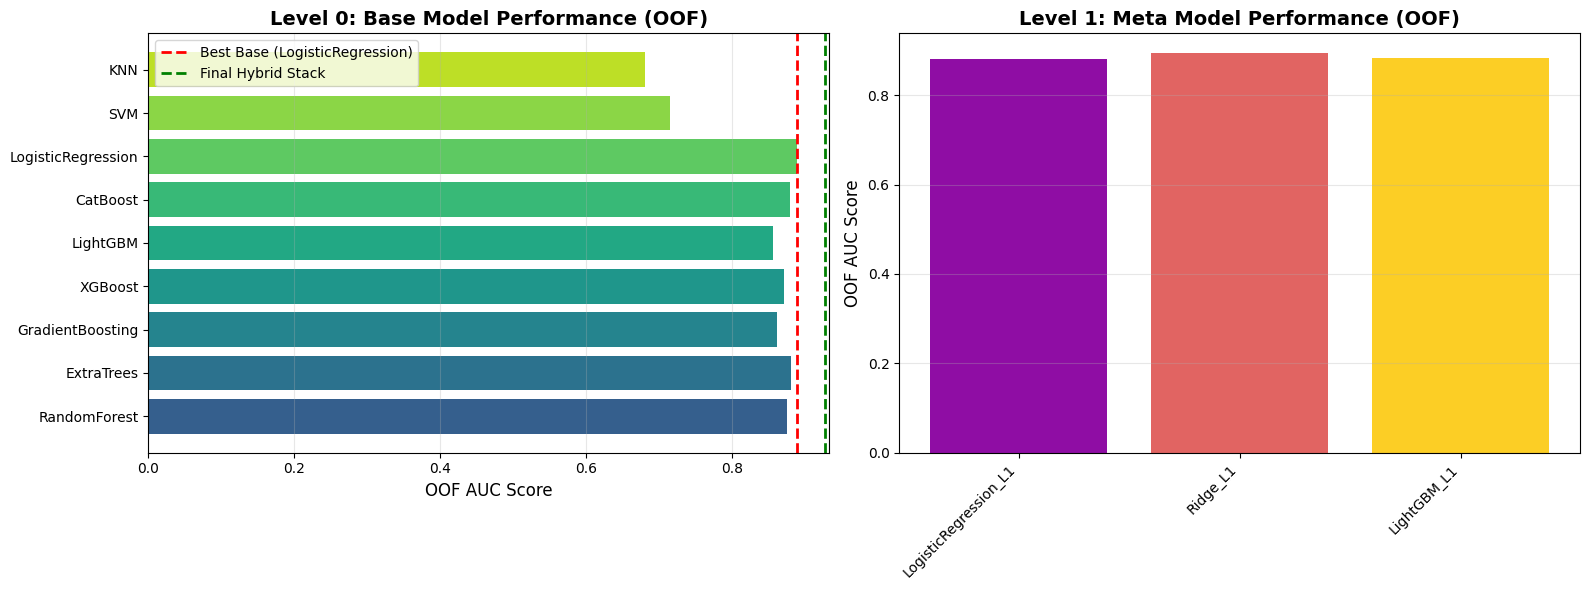

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot 1: Level 0 & Level 1 Model Performance ---
print("\n[Plot 1] Generating OOF Model Performance Plot...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Level 0 Model Performance
l0_names = list(oof_scores_l0.keys())
l0_scores = list(oof_scores_l0.values())
colors_l0 = plt.cm.viridis(np.linspace(0.3, 0.9, len(l0_names)))
bars1 = ax1.barh(l0_names, l0_scores, color=colors_l0)
ax1.axvline(x=best_l0_score, color='red', linestyle='--', linewidth=2, label=f'Best Base ({best_l0_name})')
ax1.axvline(x=final_auc, color='green', linestyle='--', linewidth=2, label='Final Hybrid Stack')
ax1.set_xlabel('OOF AUC Score', fontsize=12)
ax1.set_title('Level 0: Base Model Performance (OOF)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Level 1 Model Performance
l1_names = list(oof_scores_l1.keys())
l1_scores = list(oof_scores_l1.values())
colors_l1 = plt.cm.plasma(np.linspace(0.3, 0.9, len(l1_names)))
ax2.bar(range(len(l1_names)), l1_scores, color=colors_l1)
ax2.set_xticks(range(len(l1_names)))
# Adjusted label extraction for clarity
ax2.set_xticklabels([n.replace('level1_', '') for n in l1_names], rotation=45, ha='right')
ax2.set_ylabel('OOF AUC Score', fontsize=12)
ax2.set_title('Level 1: Meta Model Performance (OOF)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('1_oof_model_performance.png', dpi=300)
plt.show()

2. Confusion Matrix
This plot visualizes the classification results of the final model on the test set.


[Plot 2] Generating Confusion Matrix Plot...


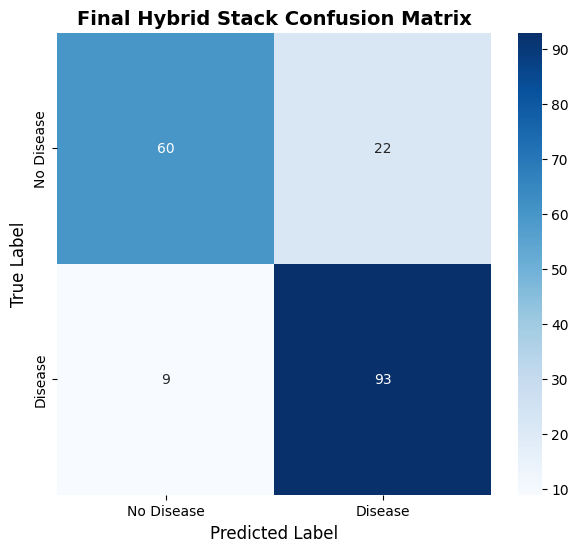

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Plot 2: Confusion Matrix ---
print("\n[Plot 2] Generating Confusion Matrix Plot...")

# Assuming 'cm' is already defined as confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Final Hybrid Stack Confusion Matrix', fontsize=14, fontweight='bold')
plt.savefig('2_confusion_matrix.png', dpi=300)
plt.show()

3. ROC Curve Comparison
This plot compares the diagnostic ability of the final ensemble against the best base model.


[Plot 3] Generating ROC Curve Plot...


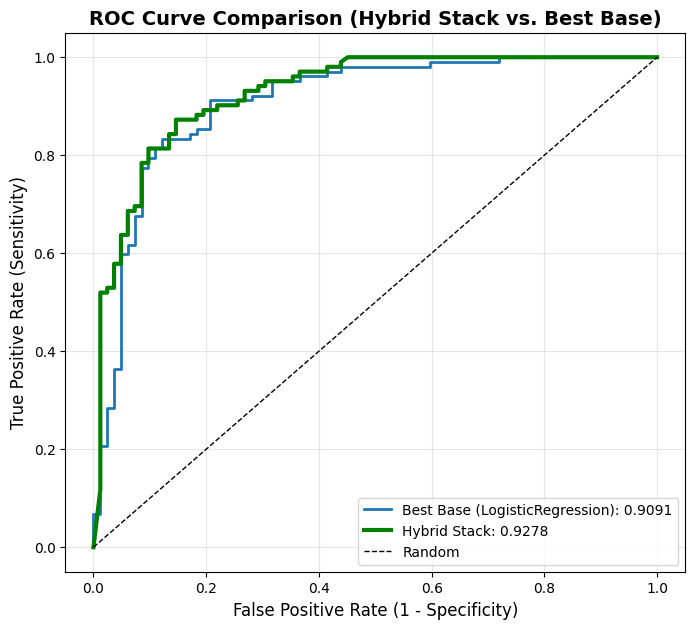

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Plot 3: ROC Curve Comparison ---
print("\n[Plot 3] Generating ROC Curve Plot...")

# You must redefine best_model and fit it here if you didn't keep it
best_model = level0_models[best_l0_name]
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict_proba(X_test)[:, 1]
# Note: final_auc and y_pred_proba should be defined from your final ensemble step

plt.figure(figsize=(8, 7))

# Plot ROC for best base model
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_pred_best)
plt.plot(fpr_best, tpr_best, linewidth=2, label=f'Best Base ({best_l0_name}): {auc_best:.4f}')

# Plot ROC for final ensemble
fpr_final, tpr_final, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_final, tpr_final, linewidth=3, label=f'Hybrid Stack: {final_auc:.4f}', color='green')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curve Comparison (Hybrid Stack vs. Best Base)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('3_roc_curve_comparison.png', dpi=300)
plt.show()

4. Level 2 (Final Blender) Feature Importance
This plot shows which models' predictions (Level 0 and Level 1) the final blender relies on most.


[Plot 4] Generating Level 2 Feature Importance Plot...


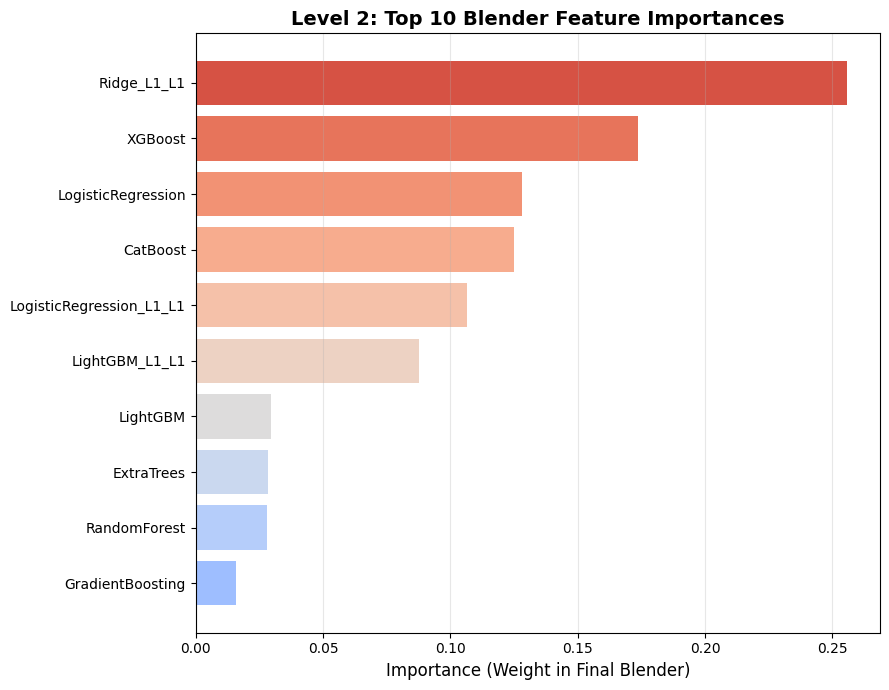

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot 4: Level 2 Feature Importance ---
print("\n[Plot 4] Generating Level 2 Feature Importance Plot...")

# Feature names for Level 2 (L0 predictions + L1 predictions)
feature_names_l2 = (
    list(level0_models.keys()) +
    [f"{name}_L1" for name in level1_models.keys()]
)
# Importance must come from your final blender (e.g., XGBoost)
importance_l2 = level2_model.feature_importances_

sorted_idx = np.argsort(importance_l2)[::-1][:10]  # Top 10
sorted_names = [feature_names_l2[i] for i in sorted_idx][::-1]
sorted_importance = importance_l2[sorted_idx][::-1]

plt.figure(figsize=(9, 7))
plt.barh(
    sorted_names,
    sorted_importance,
    color=plt.cm.coolwarm(np.linspace(0.3, 0.9, len(sorted_names)))
)
plt.xlabel('Importance (Weight in Final Blender)', fontsize=12)
plt.title('Level 2: Top 10 Blender Feature Importances', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('4_level2_feature_importance.png', dpi=300)
plt.show()


[Plot 5] Generating Architecture Summary Plot...


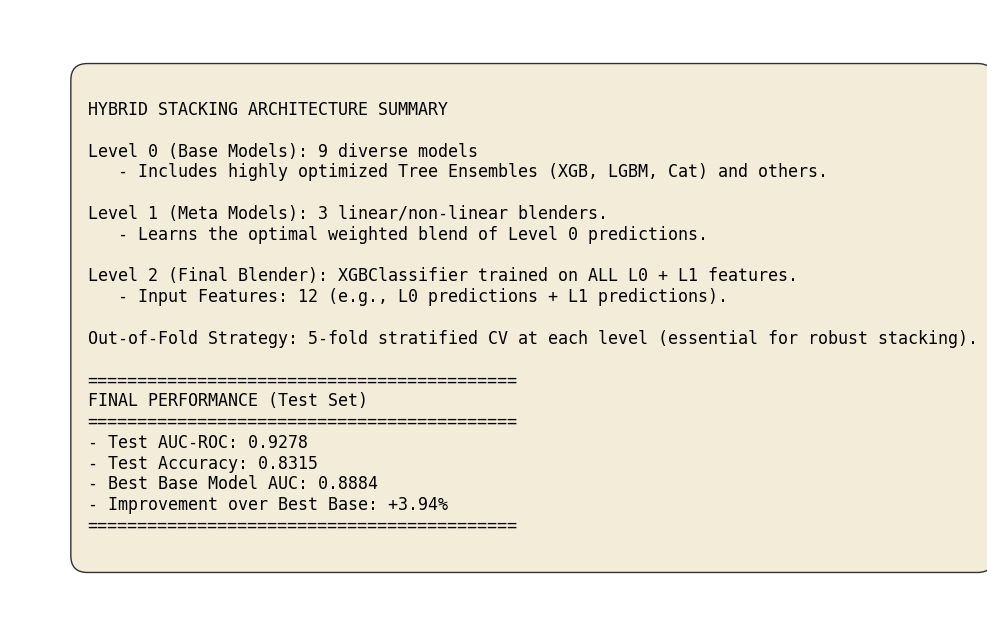

In [122]:
import matplotlib.pyplot as plt

# --- Plot 5: Architecture and Summary ---
print("\n[Plot 5] Generating Architecture Summary Plot...")

fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')

# Ensure final_acc and improvement are defined from your previous steps
# Example calculation if improvement is not yet defined:
# improvement = ((final_auc - best_l0_score) / best_l0_score) * 100

architecture_text = f"""
HYBRID STACKING ARCHITECTURE SUMMARY

Level 0 (Base Models): {len(level0_models)} diverse models
   - Includes highly optimized Tree Ensembles (XGB, LGBM, Cat) and others.

Level 1 (Meta Models): {len(level1_models)} linear/non-linear blenders.
   - Learns the optimal weighted blend of Level 0 predictions.

Level 2 (Final Blender): {type(level2_model).__name__} trained on ALL L0 + L1 features.
   - Input Features: {X_train_l2.shape[1]} (e.g., L0 predictions + L1 predictions).

Out-of-Fold Strategy: 5-fold stratified CV at each level (essential for robust stacking).

===========================================
FINAL PERFORMANCE (Test Set)
===========================================
- Test AUC-ROC: {final_auc:.4f}
- Test Accuracy: {final_acc:.4f}
- Best Base Model AUC: {best_l0_score:.4f}
- Improvement over Best Base: +{improvement:.2f}%
===========================================
"""

ax.text(0.1, 0.5, architecture_text, fontsize=12, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round,pad=1', facecolor='#f0e8d0', alpha=0.8))

plt.savefig('5_architecture_summary.png', dpi=300, bbox_inches='tight')
plt.show()

## COMPREHENSIVE FEATURE SELECTION PIPELINE

result comaprison before and after feature selection for Random forest, XGBoost, Logistic regression

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import (
    SelectKBest, f_classif, chi2, RFE, RFECV
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("COMPREHENSIVE FEATURE SELECTION PIPELINE")
print("="*80)

COMPREHENSIVE FEATURE SELECTION PIPELINE


In [15]:
# ============================================================================
# STEP 0: Prepare Data (Train-Test Split FIRST - Critical!)
# ============================================================================
print("\n[STEP 0] Splitting data (BEFORE feature selection to avoid leakage)...")

X = df_fe.drop('target', axis=1)
y = df_fe['target']

# Split BEFORE any feature selection
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Training set: {X_train.shape}")
print(f"✓ Test set: {X_test.shape}")
print(f"✓ Starting features: {X_train.shape[1]}")

# Store original feature names
original_features = X_train.columns.tolist()


[STEP 0] Splitting data (BEFORE feature selection to avoid leakage)...
✓ Training set: (736, 24)
✓ Test set: (184, 24)
✓ Starting features: 24


In [16]:
# ============================================================================
# STAGE 1: FILTER METHODS (Initial Screening)
# ============================================================================
print("\n" + "="*80)
print("STAGE 1: FILTER METHODS - Initial Screening")
print("="*80)


STAGE 1: FILTER METHODS - Initial Screening


In [17]:
# ---------------------------------------------------------------------------
# 1.1: Correlation Analysis - Remove Highly Correlated Features
# ---------------------------------------------------------------------------
print("\n[1.1] Removing highly correlated features (threshold: 0.90)...")

# Calculate correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.90
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.90)]

print(f"  Features to drop due to high correlation: {len(to_drop_corr)}")
if to_drop_corr:
    print(f"  Dropped features: {to_drop_corr}")

# Remove highly correlated features
X_train_filter = X_train.drop(columns=to_drop_corr)
X_test_filter = X_test.drop(columns=to_drop_corr)

print(f"✓ Remaining features after correlation filter: {X_train_filter.shape[1]}")


[1.1] Removing highly correlated features (threshold: 0.90)...
  Features to drop due to high correlation: 2
  Dropped features: ['age_chol_interaction', 'oldpeak_thalach_ratio']
✓ Remaining features after correlation filter: 22


In [18]:
# ---------------------------------------------------------------------------
# 1.2: ANOVA F-test - Statistical Significance
# ---------------------------------------------------------------------------
print("\n[1.2] ANOVA F-test for feature-target relationship...")

# Apply SelectKBest with ANOVA F-test
selector_anova = SelectKBest(score_func=f_classif, k='all')
selector_anova.fit(X_train_filter, y_train)

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': X_train_filter.columns,
    'F_Score': selector_anova.scores_,
    'P_Value': selector_anova.pvalues_
}).sort_values('F_Score', ascending=False)

print("\nTop 15 features by F-Score:")
print(feature_scores.head(15).to_string(index=False))

# Keep features with p-value < 0.05 (statistically significant)
significant_features = feature_scores[feature_scores['P_Value'] < 0.05]['Feature'].tolist()
print(f"\n✓ Features with p < 0.05: {len(significant_features)}")

# Update datasets
X_train_filter = X_train_filter[significant_features]
X_test_filter = X_test_filter[significant_features]

print(f"✓ Remaining features after ANOVA filter: {X_train_filter.shape[1]}")

# Save Stage 1 results
stage1_features = X_train_filter.columns.tolist()


[1.2] ANOVA F-test for feature-target relationship...

Top 15 features by F-Score:
              Feature    F_Score      P_Value
angina_severity_score 278.855559 2.642435e-53
               cp_4.0 233.491597 5.671885e-46
                exang 166.644220 1.667898e-34
               cp_2.0 131.716112 3.700236e-28
              thalach 128.444225 1.500767e-27
              oldpeak 102.509376 1.214328e-22
     has_zero_oldpeak  97.887116 9.464898e-22
                  age  77.827686 8.126985e-18
                  sex  75.263767 2.633352e-17
                 chol  53.118719 8.132473e-13
             thal_7.0  51.948444 1.418135e-12
               cp_3.0  27.941539 1.650712e-07
                   ca  24.465000 9.387731e-07
             trestbps   9.297593 2.377030e-03
          restecg_1.0   9.232468 2.461969e-03

✓ Features with p < 0.05: 19
✓ Remaining features after ANOVA filter: 19



STAGE 2: WRAPPER METHODS - Recursive Feature Elimination (RFE)

[2.1] Running RFE with Logistic Regression...

✓ Optimal number of features: 15
✓ Selected features: 15


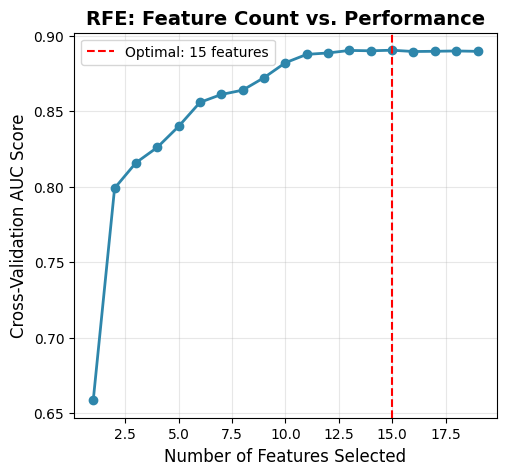

In [19]:
# ============================================================================
# STAGE 2: WRAPPER METHODS (RFE - Recursive Feature Elimination)
# ============================================================================
print("\n" + "="*80)
print("STAGE 2: WRAPPER METHODS - Recursive Feature Elimination (RFE)")
print("="*80)

print("\n[2.1] Running RFE with Logistic Regression...")

# Use Logistic Regression as the estimator
log_reg = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# RFECV - automatically finds optimal number of features using cross-validation
rfecv = RFECV(
    estimator=log_reg,
    step=1,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

rfecv.fit(X_train_filter, y_train)

# Get selected features
rfe_selected_features = X_train_filter.columns[rfecv.support_].tolist()

print(f"\n✓ Optimal number of features: {rfecv.n_features_}")
print(f"✓ Selected features: {len(rfe_selected_features)}")

# Plot number of features vs. cross-validation scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'],
         linewidth=2, color='#2E86AB', marker='o')
plt.axvline(x=rfecv.n_features_, color='red', linestyle='--',
            label=f'Optimal: {rfecv.n_features_} features')
plt.xlabel('Number of Features Selected', fontsize=12)
plt.ylabel('Cross-Validation AUC Score', fontsize=12)
plt.title('RFE: Feature Count vs. Performance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Update datasets with RFE results
X_train_wrapper = X_train_filter[rfe_selected_features]
X_test_wrapper = X_test_filter[rfe_selected_features]

# Save Stage 2 results
stage2_features = rfe_selected_features


STAGE 3: EMBEDDED METHODS - XGBoost Feature Importance

[3.1] Training XGBoost and extracting feature importance...

XGBoost Feature Importance Rankings:
              Feature  Importance
angina_severity_score    0.231591
               cp_4.0    0.166573
                  sex    0.073663
               cp_2.0    0.065178
             thal_7.0    0.052061
                 chol    0.048528
              oldpeak    0.047954
                  age    0.047616
          restecg_1.0    0.043625
                   ca    0.043203
                exang    0.043053
               cp_3.0    0.038099
            slope_2.0    0.035634
                  fbs    0.032069
   chol_thalach_ratio    0.031152

✓ Features explaining 95% of importance: 14

✓ Saved visualization: feature_selection_analysis.png


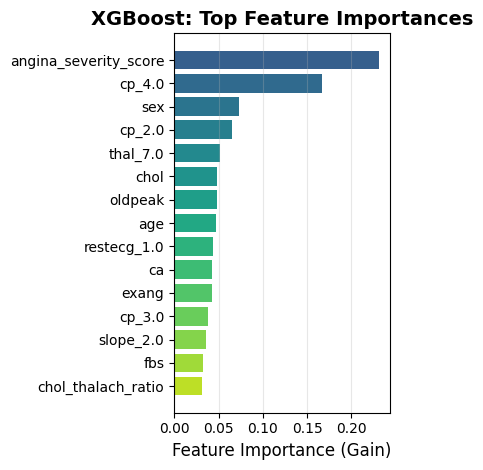

In [20]:
# ============================================================================
# STAGE 3: EMBEDDED METHODS (XGBoost Feature Importance)
# ============================================================================
print("\n" + "="*80)
print("STAGE 3: EMBEDDED METHODS - XGBoost Feature Importance")
print("="*80)

print("\n[3.1] Training XGBoost and extracting feature importance...")

# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_wrapper, y_train)

# Get feature importance (gain-based)
importance_df = pd.DataFrame({
    'Feature': X_train_wrapper.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nXGBoost Feature Importance Rankings:")
print(importance_df.to_string(index=False))

# Select top K features based on importance (keep features contributing to 95% cumulative importance)
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()
importance_df['Cumulative_Percentage'] = (
    importance_df['Cumulative_Importance'] / importance_df['Importance'].sum() * 100
)

# Keep features until 95% cumulative importance
threshold_95 = 0.95
cumsum = importance_df['Importance'].cumsum() / importance_df['Importance'].sum()
n_features_95 = (cumsum <= threshold_95).sum() + 1

final_selected_features = importance_df.head(n_features_95)['Feature'].tolist()

print(f"\n✓ Features explaining 95% of importance: {len(final_selected_features)}")

# Visualize feature importance
plt.subplot(1, 2, 2)
top_n = min(15, len(importance_df))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))
plt.barh(importance_df['Feature'].head(top_n)[::-1],
         importance_df['Importance'].head(top_n)[::-1],
         color=colors[::-1])
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.title('XGBoost: Top Feature Importances', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_selection_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved visualization: feature_selection_analysis.png")
plt.show()

# Final datasets with selected features
X_train_final = X_train_wrapper[final_selected_features]
X_test_final = X_test_wrapper[final_selected_features]

# Save Stage 3 results
stage3_features = final_selected_features

In [21]:
# ============================================================================
# FINAL SUMMARY AND COMPARISON
# ============================================================================
print("\n" + "="*80)
print("FEATURE SELECTION SUMMARY")
print("="*80)

summary_df = pd.DataFrame({
    'Stage': [
        'Original',
        'After Correlation Filter',
        'After ANOVA Filter',
        'After RFE (Wrapper)',
        'After XGBoost (Embedded)'
    ],
    'Number of Features': [
        len(original_features),
        len(X_train_filter.columns),
        len(stage1_features),
        len(stage2_features),
        len(stage3_features)
    ],
    'Reduction (%)': [
        0,
        round((1 - len(X_train_filter.columns)/len(original_features)) * 100, 1),
        round((1 - len(stage1_features)/len(original_features)) * 100, 1),
        round((1 - len(stage2_features)/len(original_features)) * 100, 1),
        round((1 - len(stage3_features)/len(original_features)) * 100, 1)
    ]
})

print("\n" + summary_df.to_string(index=False))

print("\n" + "="*80)
print("FINAL SELECTED FEATURES")
print("="*80)
print(f"\nTotal: {len(final_selected_features)} features")
print("\nSelected features (in order of importance):")
for i, feat in enumerate(final_selected_features, 1):
    importance = importance_df[importance_df['Feature'] == feat]['Importance'].values[0]
    print(f"  {i:2d}. {feat:<30s} (Importance: {importance:.4f})")

# ============================================================================
# EXPORT RESULTS
# ============================================================================
print("\n" + "="*80)
print("EXPORTING RESULTS")
print("="*80)

# Save selected features to CSV for future use
selected_features_df = pd.DataFrame({
    'Feature': final_selected_features,
    'XGBoost_Importance': [
        importance_df[importance_df['Feature'] == f]['Importance'].values[0]
        for f in final_selected_features
    ]
})
selected_features_df.to_csv('selected_features.csv', index=False)
print("✓ Saved: selected_features.csv")

# Save the processed datasets
X_train_final.to_csv('X_train_selected.csv', index=False)
X_test_final.to_csv('X_test_selected.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("✓ Saved: X_train_selected.csv")
print("✓ Saved: X_test_selected.csv")
print("✓ Saved: y_train.csv")
print("✓ Saved: y_test.csv")


FEATURE SELECTION SUMMARY

                   Stage  Number of Features  Reduction (%)
                Original                  24            0.0
After Correlation Filter                  19           20.8
      After ANOVA Filter                  19           20.8
     After RFE (Wrapper)                  15           37.5
After XGBoost (Embedded)                  14           41.7

FINAL SELECTED FEATURES

Total: 14 features

Selected features (in order of importance):
   1. angina_severity_score          (Importance: 0.2316)
   2. cp_4.0                         (Importance: 0.1666)
   3. sex                            (Importance: 0.0737)
   4. cp_2.0                         (Importance: 0.0652)
   5. thal_7.0                       (Importance: 0.0521)
   6. chol                           (Importance: 0.0485)
   7. oldpeak                        (Importance: 0.0480)
   8. age                            (Importance: 0.0476)
   9. restecg_1.0                    (Importance: 0.0436)


In [22]:
# ============================================================================
# PERFORMANCE COMPARISON (Before vs After Feature Selection)
# ============================================================================
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

from sklearn.metrics import roc_auc_score, accuracy_score

# Train models with ALL features vs SELECTED features
models_to_test = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = []

for model_name, model in models_to_test.items():
    # Train with ALL features (from stage 1 - after correlation/ANOVA filter)
    model_all = type(model)(**model.get_params())
    model_all.fit(X_train_filter, y_train)
    y_pred_all = model_all.predict_proba(X_test_filter)[:, 1]
    auc_all = roc_auc_score(y_test, y_pred_all)
    acc_all = accuracy_score(y_test, (y_pred_all >= 0.5).astype(int))

    # Train with SELECTED features
    model_selected = type(model)(**model.get_params())
    model_selected.fit(X_train_final, y_train)
    y_pred_selected = model_selected.predict_proba(X_test_final)[:, 1]
    auc_selected = roc_auc_score(y_test, y_pred_selected)
    acc_selected = accuracy_score(y_test, (y_pred_selected >= 0.5).astype(int))

    results.append({
        'Model': model_name,
        'All_Features_AUC': auc_all,
        'Selected_Features_AUC': auc_selected,
        'AUC_Improvement': auc_selected - auc_all,
        'All_Features_Accuracy': acc_all,
        'Selected_Features_Accuracy': acc_selected,
        'Acc_Improvement': acc_selected - acc_all
    })

comparison_df = pd.DataFrame(results)
print("\n" + comparison_df.to_string(index=False))

print("\n" + "="*80)
print("FEATURE SELECTION COMPLETE!")
print("="*80)
print("\n✓ You can now use X_train_final and X_test_final for your models")
print("✓ Benefits:")
print("  • Reduced dimensionality for faster training")
print("  • Removed redundant/irrelevant features")
print("  • Better generalization (less overfitting)")
print("  • Improved interpretability")
print("\n✓ Next steps:")
print("  1. Train Deep Learning models with selected features")
print("  2. Run Stacking Ensemble with selected features")
print("  3. Compare performance with previous results")
print("="*80)


PERFORMANCE COMPARISON

              Model  All_Features_AUC  Selected_Features_AUC  AUC_Improvement  All_Features_Accuracy  Selected_Features_Accuracy  Acc_Improvement
Logistic Regression          0.905308               0.901184        -0.004125               0.853261                    0.853261         0.000000
      Random Forest          0.919357               0.920911         0.001554               0.831522                    0.853261         0.021739
            XGBoost          0.875897               0.901303         0.025407               0.826087                    0.842391         0.016304

FEATURE SELECTION COMPLETE!

✓ You can now use X_train_final and X_test_final for your models
✓ Benefits:
  • Reduced dimensionality for faster training
  • Removed redundant/irrelevant features
  • Better generalization (less overfitting)
  • Improved interpretability

✓ Next steps:
  1. Train Deep Learning models with selected features
  2. Run Stacking Ensemble with selected features
